# ENDG 511 Project: Classifying Cassava Plants 
By: Matthew Ocando & Daphne Hong

In [2]:
!pip install -q tensorflow-model-optimization

# import statements
import tensorflow as tf
import tempfile
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow_model_optimization as tfmot
from keras.utils.layer_utils import count_params
from tqdm.notebook import trange, tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 19.4 MB/s eta 0:00:00


In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# map disease code to disease name
label_map = {"0": "Cassava Bacterial Blight (CBB)", 
          "1": "Cassava Brown Streak Disease (CBSD)", 
          "2": "Cassava Green Mottle (CGM)", 
          "3": "Cassava Mosaic Disease (CMD)", 
          "4": "Healthy"}

In [5]:
# load in labels from csv
data = pd.read_csv('/content/gdrive/MyDrive/ENDG511-Project/train.csv') 
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
# count the number of different labels in the dataset
data['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

*train.csv* is a csv file that includes 2 columns:

*   *image_id* : name of image in dataset
*   *label* : disease code that maps to a disease name

Disease code 3 (Cassava Mosaic Disease) dominates over the other classes. There are similar amounts of data samples for disease codes 4, 2, and 1 (Healthy, Cassava Green Mottle, and Cassava Brown Streak Disease respectively) and few data samples for disease code 0 (Cassava Bacterial Blight).

Due to the unequal representation of each class, the machine learning model may be biased towards disease code 3 in its prediction.



In [ ]:
# extract files from cassava-leaf-disease-classification.zip
from zipfile import ZipFile
file_name = '/content/gdrive/MyDrive/ENDG511-Project/cassava-leaf-disease-classification.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

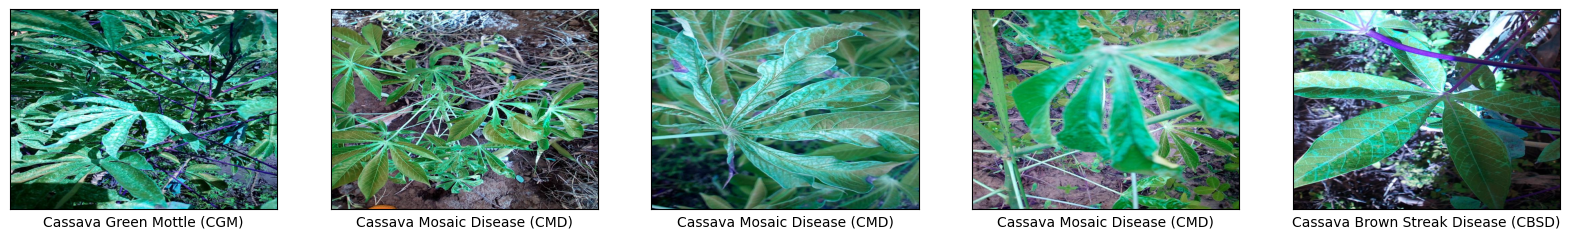

In [7]:
# check training images
plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(1,5)
n=0
for col in ax:
  n=n+100
  img = cv2.imread('/content/train_images/'+data['image_id'][n], cv2.IMREAD_UNCHANGED)
  col.imshow(img)
  col.set_xticks([])
  col.set_yticks([])
  col.set_xlabel(label_map.get(str(data['label'][n])))
plt.show()


In [8]:
# check for missing values
data.isna().sum()

image_id    0
label       0
dtype: int64

No values are missing, so no additional data cleaning is required.

In [9]:
# convert labels to strings for Image Data Generator
data.label = data.label.astype(str)

# split data into training and testing sets - use 80/20 ratio
train_images, test_images = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=0)

In [10]:
# initialize the Image Data Generator class - data augmentation
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.0,
                                                            rotation_range=20,
                                                            zoom_range=0.05,
                                                            width_shift_range=0.05,
                                                            height_shift_range=0.05,
                                                            shear_range=0.05,
                                                            horizontal_flip=True)

# initialize training generator
IG_train = ImageFlow.flow_from_dataframe(train_images,directory='/content/train_images/',x_col='image_id',
                                         y_col='label',batch_size=100,seed=30,target_size=(128,128))

# initialize testing generator
IG_test = ImageFlow.flow_from_dataframe(test_images,directory='/content/train_images/',x_col='image_id',
                                        y_col='label',batch_size=100,seed=30,target_size=(128,128))

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


## Transfer Learning

Next, we will import MobileNet with weights pre-trained on the ImageNet dataset. The final fully-connected layer will not be transferred (include_top=False) since the classification problem in this project has a different number of classes than the data in ImageNet.

Since it is easier to manage the Keras Sequential Model class (as opposed to Functional Model class), we will also move these weights over to said model type.

In [ ]:
# Load in MobileNetV1 with pre-trained weights on ImageNet
load_model = tf.keras.applications.MobileNet(
                  input_shape=IG_train.image_shape,
                  alpha=1.0,
                  include_top=False,
                  weights='imagenet',
                  input_tensor=None,
                  pooling='max',
                  classifier_activation='softmax'
              )

# Convert from functional to sequential model
base_model = tf.keras.models.Sequential()
for layer in load_model.layers:
  base_model.add(layer)

# Need to add an output (dense) layer with random weights since include_top=False
base_model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Print model summary
base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                          
                                                         

Now, we create a model with the same architecture as MobileNetV1, but initialized with random weights instead.

In [ ]:
load_model = tf.keras.applications.MobileNet(
                  input_shape=IG_train.image_shape,
                  alpha=1.0,
                  include_top=True,
                  weights=None,
                  input_tensor=None,
                  pooling='max',
                  classes=5,
                  classifier_activation='softmax'
              )

random_model = tf.keras.models.Sequential()
for layer in load_model.layers:
  random_model.add(layer)

random_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 64, 64, 32)       

The transfer_model() function defined below is responsible for transferring a varying number of layers from the pre-trained MobileNetV1.

In [ ]:
def transfer_model(layerNum_list, base_model, random_model, batch_size=254, IG_train=None, IG_test=None, Trainable=False):
  
  evaluation={}
 
  # The core logic of AnB architecture 
  # Create a model in each out loop and evaluate it 
  for i in range(len(layerNum_list)):

    # Create a new sequential model
    model_new = models.Sequential()
    input_shape = (128, 128, 3) # NEW EDITS # 

    # Add the first layer with input shape
    model_new.add(layers.InputLayer(input_shape=input_shape)) # NEW EDITS # 

    # Create the base_model layers that are transferred
    base_model_layers = []
    for n in range(layerNum_list[i]-1, -len(base_model.layers)-1, -1):
      
      # Define whether transferred base layers are trainable or not
      base_model.layers[n].trainable = Trainable

      base_model_layers.append(base_model.get_layer(index = n))

    base_model_layers.reverse()

    # Create the model layers that are randomly initialized
    random_model_layers = []
    for n in range(-1,layerNum_list[i]-1,-1):
      random_model_layers.append(random_model.get_layer(index = n))
    random_model_layers.reverse()
    
    # Create the new model
    for layer in base_model_layers:
      model_new.add(layer)
    for layer in random_model_layers:
      model_new.add(layer)

    # Defining callbacks
    # Call back 1: 
    base_learning_rate = 0.001
    ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # Call back 2: 
    RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

    # Compiling each model
    model_new.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    # Training each model
    # Saving the iteration's output (accuracies) to use it at a later stage
    print('\n MODEL',i+1, 'TRAINING STARTED ... ')
    model_new.fit(IG_train, batch_size=batch_size, epochs=2, validation_data=IG_test, callbacks=[ES,RLR])

    # Check trainable parameters
    trainable_count = count_params(model_new.trainable_weights)
    non_trainable_count = count_params(model_new.non_trainable_weights)
    print('Trainable Parameters:', trainable_count)
    print('Non-Trainable Parameters:', non_trainable_count, '\n')

    evaluation[i] = model_new.evaluate(IG_test,verbose=0)
    print('\n MODEL', i+1, 'TRAINING ENDED ... ')

  return evaluation  


The following approach involves splitting the model architecture into 13 sections and transferring certain portions at a time.

In [ ]:
layers_list = [int(x) for x in np.linspace(-len(base_model.layers)+1, -9, 12)]

First, we will evaluate performance without fine tuning.

In [ ]:
evaluation = transfer_model(layers_list, base_model=base_model, random_model=random_model, batch_size=254, \
                                                               IG_train=IG_train, IG_test=IG_test, Trainable=False)


 MODEL 1 TRAINING STARTED ... 
Epoch 1/2
172/172 [==============================] - 367s 2s/step - loss: 1.1508 - accuracy: 0.6113 - val_loss: 1.2182 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 2/2
172/172 [==============================] - 259s 2s/step - loss: 1.0365 - accuracy: 0.6356 - val_loss: 1.2490 - val_accuracy: 0.6150 - lr: 0.0010
Trainable Parameters: 3210885
Non-Trainable Parameters: 22688 


 MODEL 1 TRAINING ENDED ... 

 MODEL 2 TRAINING STARTED ... 
Epoch 1/2
172/172 [==============================] - 289s 2s/step - loss: 0.9338 - accuracy: 0.6546 - val_loss: 1.8601 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 2/2
172/172 [==============================] - 284s 2s/step - loss: 0.8125 - accuracy: 0.6901 - val_loss: 0.8925 - val_accuracy: 0.6657 - lr: 0.0010
Trainable Parameters: 3208069
Non-Trainable Parameters: 25344 


 MODEL 2 TRAINING ENDED ... 

 MODEL 3 TRAINING STARTED ... 
Epoch 1/2
172/172 [==============================] - 275s 2s/step - loss: 0.9697 - accuracy: 0.6

Save the training results to text files so that the model need not be re-trained every time the code is run.

In [ ]:
# Save results to text files
file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'evaluation'+'.txt','w')
for key,value in evaluation.items():
  file.write(str(value)+"\n")
file.close()

In [ ]:
# Load evaluation results from text files
evaluation={}

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'evaluation'+'.txt','r')
lines = file.readlines()
j=0
for l in lines:
  evaluation[j] = [float(x) for x in l.replace('\n','').replace('[','').replace(']','').split(',')]
  j+=1
file.close()

Next, we will allow fine tuning and evaluate performance.

In [ ]:
evaluation_plus = transfer_model(layers_list, base_model=base_model, random_model=random_model, batch_size=254, \
                                                               IG_train=IG_train, IG_test=IG_test, Trainable=True)


 MODEL 1 TRAINING STARTED ... 
Epoch 1/2
172/172 [==============================] - 307s 2s/step - loss: 1.0062 - accuracy: 0.6419 - val_loss: 1.6525 - val_accuracy: 0.1213 - lr: 0.0010
Epoch 2/2
172/172 [==============================] - 260s 2s/step - loss: 0.9115 - accuracy: 0.6616 - val_loss: 2.3996 - val_accuracy: 0.1446 - lr: 0.0010
Trainable Parameters: 3211749
Non-Trainable Parameters: 21824 


 MODEL 1 TRAINING ENDED ... 

 MODEL 2 TRAINING STARTED ... 
Epoch 1/2
172/172 [==============================] - 292s 2s/step - loss: 0.7981 - accuracy: 0.6993 - val_loss: 1.4428 - val_accuracy: 0.6320 - lr: 0.0010
Epoch 2/2
172/172 [==============================] - 277s 2s/step - loss: 0.6925 - accuracy: 0.7404 - val_loss: 1.2758 - val_accuracy: 0.6857 - lr: 0.0010
Trainable Parameters: 3211525
Non-Trainable Parameters: 21888 


 MODEL 2 TRAINING ENDED ... 

 MODEL 3 TRAINING STARTED ... 
Epoch 1/2
172/172 [==============================] - 305s 2s/step - loss: 0.8513 - accuracy: 0.6

In [ ]:
# Save results to text files
file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'evaluation_plus'+'.txt','w')
for key,value in evaluation_plus.items():
  file.write(str(value)+"\n")
file.close()

In [ ]:
# Load evaluation results from text files
evaluation_plus={}

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'evaluation_plus'+'.txt','r')
lines = file.readlines()
j=0
for l in lines:
  evaluation_plus[j] = [float(x) for x in l.replace('\n','').replace('[','').replace(']','').split(',')]
  j+=1
file.close()

Finally, we will plot a graph showing the change in accuracy versus the number of transferred layers.

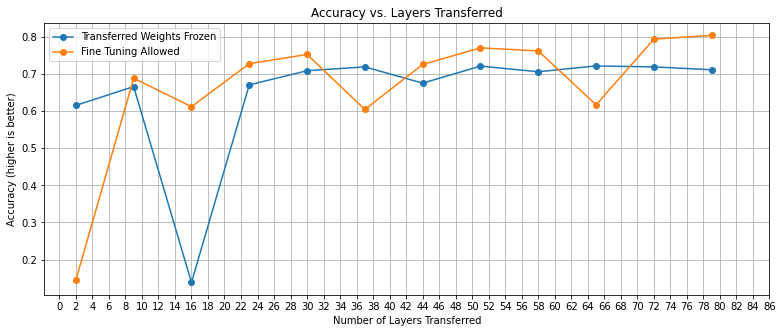

[-86, -79, -72, -65, -58, -51, -44, -37, -30, -23, -16, -9]


In [ ]:
# Plot accuracy versus number of transferred layers
plt.rcParams["figure.figsize"] = (13,5)
accuracies = []
accuracies_plus = []
layers_transferred = [len(base_model.layers)+1+x for x in layers_list]
for k,v in evaluation.items():
  accuracies.append(v[1])
for k,v in evaluation_plus.items():
  accuracies_plus.append(v[1])

plt.plot(layers_transferred,accuracies,label = 'Transferred Weights Frozen',marker='o')
plt.plot(layers_transferred,accuracies_plus,label = 'Fine Tuning Allowed',marker='o')
plt.xlabel('Number of Layers Transferred')
plt.ylabel('Accuracy (higher is better)')
plt.title('Accuracy vs. Layers Transferred')
plt.xticks(range(0,len(base_model.layers),2))
plt.grid()
plt.legend()
plt.show()
print(layers_list)

Observing the above trend, it would appear that transferring '86' trainable layers produces optimal accuracy results. As such, we will move forward using this model. We will retrain for 10 epochs.

In [ ]:
# Create a new sequential model
tf_layers = -86
model_new = models.Sequential()
input_shape = (128, 128, 3) # NEW EDITS # 

# Add the first layer with input shape
model_new.add(layers.InputLayer(input_shape=input_shape)) # NEW EDITS # 

# Create the base_model layers that are transferred
base_model_layers = []
for n in range(tf_layers-1, -len(base_model.layers)-1, -1):
     
  # Define whether transferred base layers are trainable or not
  base_model.layers[n].trainable = True

  base_model_layers.append(base_model.get_layer(index = n))

base_model_layers.reverse()

# Create the model layers that are randomly initialized
random_model_layers = []
for n in range(-1, tf_layers-1, -1):
  random_model_layers.append(random_model.get_layer(index = n))
random_model_layers.reverse()
    
# Create the new model
for layer in base_model_layers:
  model_new.add(layer)
for layer in random_model_layers:
  model_new.add(layer)

# Defining callbacks
# Call back 1: 
base_learning_rate = 0.001
ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
# Call back 2: 
RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# Compile the model
model_new.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
model_new.fit(IG_train,batch_size=254, epochs=10,validation_data=IG_test,callbacks=[ES,RLR])

Epoch 1/10
172/172 [==============================] - 276s 2s/step - loss: 0.9314 - accuracy: 0.6592 - val_loss: 1.4739 - val_accuracy: 0.1208 - lr: 0.0010
Epoch 2/10
172/172 [==============================] - 290s 2s/step - loss: 0.8185 - accuracy: 0.6890 - val_loss: 2.6302 - val_accuracy: 0.1220 - lr: 0.0010
Epoch 3/10
172/172 [==============================] - 260s 2s/step - loss: 0.7806 - accuracy: 0.7076 - val_loss: 1.8362 - val_accuracy: 0.2271 - lr: 0.0010
Epoch 4/10
172/172 [==============================] - 289s 2s/step - loss: 0.7452 - accuracy: 0.7171 - val_loss: 1.0861 - val_accuracy: 0.5509 - lr: 0.0010
Epoch 5/10
172/172 [==============================] - 258s 1s/step - loss: 0.7296 - accuracy: 0.7242 - val_loss: 0.9892 - val_accuracy: 0.6089 - lr: 0.0010
Epoch 6/10
172/172 [==============================] - 289s 2s/step - loss: 0.7037 - accuracy: 0.7352 - val_loss: 0.9249 - val_accuracy: 0.6591 - lr: 0.0010
Epoch 7/10
172/172 [==============================] - 258s 2s/st

In [ ]:
############################################## TESTING ############################################################
# Create a new sequential model
model_new = models.Sequential()
input_shape = (128, 128, 3)

# Add the first layer with input shape
model_new.add(layers.InputLayer(input_shape=input_shape))

# Create the base_model layers that are transferred
base_model_layers = []
for n in range(-65-1, -len(base_model.layers)-1, -1):
     
  # Define whether transferred base layers are trainable or not
  base_model.layers[n].trainable = True

  base_model_layers.append(base_model.get_layer(index = n))

base_model_layers.reverse()

# Create the model layers that are randomly initialized
random_model_layers = []
for n in range(-1, -65-1, -1):
  random_model_layers.append(random_model.get_layer(index = n))
random_model_layers.reverse()
    
# Create the new model
for layer in base_model_layers:
  model_new.add(layer)
for layer in random_model_layers:
  model_new.add(layer)

# Defining callbacks
# Call back 1: 
base_learning_rate = 0.001
ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
# Call back 2: 
RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# Compile the model
model_new.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
model_new.fit(IG_train,batch_size=254, epochs=10,validation_data=IG_test,callbacks=[ES,RLR])

Epoch 1/10
172/172 [==============================] - 326s 2s/step - loss: 0.9893 - accuracy: 0.6412 - val_loss: 1.5917 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 2/10
172/172 [==============================] - 263s 2s/step - loss: 0.8593 - accuracy: 0.6781 - val_loss: 2.1643 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 3/10
172/172 [==============================] - 263s 2s/step - loss: 0.7919 - accuracy: 0.7036 - val_loss: 1.6803 - val_accuracy: 0.6145 - lr: 0.0010
Epoch 4/10
172/172 [==============================] - 297s 2s/step - loss: 0.7323 - accuracy: 0.7275 - val_loss: 1.0517 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 5/10
172/172 [==============================] - 263s 2s/step - loss: 0.6815 - accuracy: 0.7500 - val_loss: 1.4850 - val_accuracy: 0.4432 - lr: 0.0010
Epoch 6/10
172/172 [==============================] - 297s 2s/step - loss: 0.6480 - accuracy: 0.7600 - val_loss: 1.3763 - val_accuracy: 0.5037 - lr: 0.0010
Epoch 7/10
172/172 [==============================] - 264s 2s/st

In [82]:
# Saving the whole model instead of just weights
!mkdir -p /content/drive/MyDrive/ENDG_511/saved_model
model_new.save('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model')
model_new.save('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model.h5')

In [121]:
# Loading the saved model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model.h5')

## Model Compression

Now, we will apply pruning and post-training quantization in differing amounts. This will demonstrate the effects of applying differing model compression techniques in cascade and will help to identify the best model.

In [ ]:
#Create directory for saving models
!mkdir -p /content/drive/MyDrive/ENDG_511/model_compression

In [24]:
# Define a function that applies pruning
def pruning(model, target_sparsity):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Prune the model with target sparsity indicated by element in 'target_sparsity'
  pruning_params = {'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity, begin_step=0, frequency=100)}
  pruned_model = prune_low_magnitude(model, **pruning_params)

  # Train model
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy'])  
  pruned_model.fit(IG_train, epochs=3, validation_data=IG_test, 
                   callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
  pruned_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_'+str(int(target_sparsity*100))+'_model')
  stripped_pruned_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_'+str(int(target_sparsity*100))+'_model.h5')
  print('Model Saved!')

  return None

In [44]:
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  pruned_model.fit(IG_train, epochs=3, validation_data=IG_test, 
                   callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
  pruned_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_pruned_'+str(int(final_sparsity*100))+'_model')
  stripped_pruned_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_'+str(int(final_sparsity*100))+'_model.h5')
  print('Model Saved!')

  return None

In [122]:
# Define a function that applies post-training quantization
def quantization(path=None, quantization_level=8):
  
  model = tf.keras.models.load_model(path+'.h5')

  # Convert to TFLite and apply quantization
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT] # Set default optimizer (8-bit quantization)
  converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]
  if quantization_level == 16:
    converter.target_spec.supported_types = [tf.float16] # Apply 16-bit floating point quantization
  quantized_tflite_model = converter.convert()
  with open(path+'_'+str(quantization_level)+'_bit', 'wb') as f:
    f.write(quantized_tflite_model)
  with open(path+'_'+str(quantization_level)+'_bit.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

  return None

In [123]:
# Apply 10% pruning to base model
pruning(model, 0.1)

Epoch 1/3
172/172 [==============================] - 329s 2s/step - loss: 0.6110 - accuracy: 0.7724 - val_loss: 0.8056 - val_accuracy: 0.7030
Epoch 2/3
172/172 [==============================] - 319s 2s/step - loss: 0.5887 - accuracy: 0.7781 - val_loss: 0.8253 - val_accuracy: 0.7061
Epoch 3/3
172/172 [==============================] - 294s 2s/step - loss: 0.5883 - accuracy: 0.7793 - val_loss: 0.7497 - val_accuracy: 0.7343


Model Saved!


In [124]:
# Apply 30% pruning to base model
pruning(model, 0.3)

Epoch 1/3
172/172 [==============================] - 330s 2s/step - loss: 0.5775 - accuracy: 0.7820 - val_loss: 1.0352 - val_accuracy: 0.6294
Epoch 2/3
172/172 [==============================] - 293s 2s/step - loss: 0.5505 - accuracy: 0.7933 - val_loss: 0.7757 - val_accuracy: 0.7315
Epoch 3/3
172/172 [==============================] - 319s 2s/step - loss: 0.5297 - accuracy: 0.8011 - val_loss: 0.7329 - val_accuracy: 0.7364


Model Saved!


In [125]:
# Apply 50% pruning to base model
pruning(model, 0.5)

Epoch 1/3
172/172 [==============================] - 356s 2s/step - loss: 0.5518 - accuracy: 0.7916 - val_loss: 0.8886 - val_accuracy: 0.6636
Epoch 2/3
172/172 [==============================] - 298s 2s/step - loss: 0.5083 - accuracy: 0.8114 - val_loss: 1.0910 - val_accuracy: 0.6028
Epoch 3/3
172/172 [==============================] - 302s 2s/step - loss: 0.4899 - accuracy: 0.8183 - val_loss: 0.7923 - val_accuracy: 0.7222


Model Saved!


In [126]:
# Apply 80% pruning to base model
pruning(model, 0.8)

Epoch 1/3
172/172 [==============================] - 327s 2s/step - loss: 0.5911 - accuracy: 0.7755 - val_loss: 1.3523 - val_accuracy: 0.6150
Epoch 2/3
172/172 [==============================] - 297s 2s/step - loss: 0.5972 - accuracy: 0.7723 - val_loss: 0.7388 - val_accuracy: 0.7346
Epoch 3/3
172/172 [==============================] - 294s 2s/step - loss: 0.5530 - accuracy: 0.7888 - val_loss: 0.8419 - val_accuracy: 0.6986


Model Saved!


Regular pruning (what was done above), is good for comparing the the effects of pruning to different target sparsities. Iterative pruning is known to be superior to regular pruning as it has shown to give better results (e.g. higher accuracy). This is due to the pruning and retraining cycles that allow the model to fine-tune itself. Let's try iterative pruning and see how it compares to regular pruning!

In [127]:
iterative_pruning(model, 0, 0.1, 0, 1000)

Epoch 1/3
172/172 [==============================] - 327s 2s/step - loss: 0.5946 - accuracy: 0.7741 - val_loss: 0.9475 - val_accuracy: 0.6836
Epoch 2/3
172/172 [==============================] - 297s 2s/step - loss: 0.5474 - accuracy: 0.7935 - val_loss: 0.7340 - val_accuracy: 0.7421
Epoch 3/3
172/172 [==============================] - 296s 2s/step - loss: 0.5193 - accuracy: 0.8027 - val_loss: 1.0642 - val_accuracy: 0.6290


Model Saved!


In [1]:
iterative_pruning(model, 0, 0.3, 0, 1000)

NameError: ignored

In [ ]:
iterative_pruning(model, 0, 0.5, 0, 1000)

In [ ]:
iterative_pruning(model, 0, 0.8, 0, 1000)

Next, we will apply 8-bit and 16-bit quantization to each of the four pruned models (models with different target sparisities), plus the unpruned base model. We will do this for both the magnitude-pruned and iteratively-pruned models. This will be the next step in the model compression pipeline. 

In [ ]:
# Apply 8-bit quantization to the models with 4 different levels of magnitude pruning applied
quantization('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model',8)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_10_model', 8)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_30_model', 8)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_50_model', 8)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_80_model', 8)

In [ ]:
# Apply 16-bit quantization to the models with 4 different levels of magnitude pruning applied
quantization('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model',16)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_10_model', 16)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_30_model', 16)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_50_model', 16)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_80_model', 16)

In [ ]:
# Apply 8-bit quantization to the models with 4 different levels of iterative pruning applied
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_10_model', 8)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_30_model', 8)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_50_model', 8)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_80_model', 8)

In [ ]:
# Apply 16-bit quantization to the models with 4 different levels of iterative pruning applied
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_10_model', 16)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_30_model', 16)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_50_model', 16)
quantization('/content/gdrive/MyDrive/ENDG511-Project/model_compression/iter_s_p_80_model', 16)

## Model Evaluation

### 1) Preparing Metrics

In [ ]:
## Loading the saved models

# Load model (no quantization)
base_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model')
pruned_10_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_10_model')
pruned_30_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_30_model')
pruned_50_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_50_model')
pruned_80_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_80_model')

# Load the TFLite model in TFLite Interpreter (8-bit quantization)
interpreter_base_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/base_model_8_bit')
interpreter_prune_10_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_10_model_8_bit')
interpreter_prune_30_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_30_model_8_bit')
interpreter_prune_50_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_50_model_8_bit')
interpreter_prune_80_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_80_model_8_bit')

# Load the TFLite model in TFLite Interpreter (16-bit quantization)
interpreter_base_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/base_model_16_bit')
interpreter_prune_10_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_10_model_16_bit')
interpreter_prune_30_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_30_model_16_bit')
interpreter_prune_50_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_50_model_16_bit')
interpreter_prune_80_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_80_model_16_bit')

In [ ]:
models_no_quant = [base_model,pruned_10_model,pruned_30_model,pruned_50_model,pruned_80_model]
models_8_bit = [interpreter_base_8_bit,interpreter_prune_10_8_bit,interpreter_prune_30_8_bit,interpreter_prune_50_8_bit,interpreter_prune_80_8_bit]
models_16_bit = [interpreter_base_16_bit,interpreter_prune_10_16_bit,interpreter_prune_30_16_bit,interpreter_prune_50_16_bit,interpreter_prune_80_16_bit]

In [ ]:
#Create subset for quantization + pruning evaluation (TF Lite model takes long for single inference)
subset_size = 30

IG_test_subset = ImageFlow.flow_from_dataframe(test_images[0:subset_size],directory='/content/train_images/',x_col='image_id',
                                        y_col='label',batch_size=subset_size,seed=30,target_size=(128,128))

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter,subset_size=IG_test.n):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  interpreter.allocate_tensors() # NEW EDITS # 

  # Run predictions on every image in the "test" dataset.
  prediction_index = []
  i = 0 # DAPHNE'S EDITS # 
  for j in range(subset_size): # NEW EDITS # 

    test_image = IG_test[j]
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image[0][0], axis=0).astype(np.float32) # NEW EDITS # 
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    #startTime = time.time()
    interpreter.invoke()
    #executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    value = np.argmax(output()[0])
    prediction_index.append(value)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_index)):
    if prediction_index[index] == int(test_images['label'].to_numpy()[index]): # DAPHNE'S EDITS # 
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_index)

  return accuracy     

In [ ]:
accuracy_no_quant = []
accuracy_8_bit = []
accuracy_16_bit = []

counter = 1
for i in trange(len(models_no_quant)):
  model = models_no_quant[i]
  accuracy_no_quant.append(model.evaluate(IG_test_subset,verbose=0)[1])
  print('Model #',counter,'done!')
  counter += 1
print('No quantization models -> DONE!\n')

counter = 1
for i in trange(len(models_8_bit)):
  model = models_8_bit[i]
  accuracy_8_bit.append(evaluate_model(model,subset_size))
  print('Model #',counter,'done!')
  counter += 1
print('8-bit quantization models -> DONE!\n')

counter = 1
for i in trange(len(models_16_bit)):
  model = models_16_bit[i]
  accuracy_16_bit.append(evaluate_model(model,subset_size))
  print('Model #',counter,'done!')
  counter += 1
print('16-bit quantization models -> DONE!\n')


In [ ]:
# Save results to text files
file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_no_quant'+'.txt','w')
for value in accuracy_no_quant:
  file.write(str(value)+"\n")
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_8_bit'+'.txt','w')
for value in accuracy_8_bit:
  file.write(str(value)+"\n")
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_16_bit'+'.txt','w')
for value in accuracy_16_bit:
  file.write(str(value)+"\n")
file.close()

Accuracy is not sufficient information to create a confusion matrix, and as such we need prediction data.

In [ ]:
# A helper function to obtain predictions from the TF Lite model using "test" dataset.
def predict_model(interpreter,subset_size=IG_test.n):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  interpreter.allocate_tensors() # NEW EDITS # 

  # Run predictions on every image in the "test" dataset.
  prediction_index = []
  i = 0 # DAPHNE'S EDITS # 
  for j in range(subset_size): # NEW EDITS # 

    test_image = IG_test[j]
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image[0][0], axis=0).astype(np.float32) # NEW EDITS # 
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    #startTime = time.time()
    interpreter.invoke()
    #executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    value = np.argmax(output()[0])
    prediction_index.append(value)

  return prediction_index

In [ ]:
y_pred_no_quant = []
y_pred_8_bit = []
y_pred_16_bit = []

counter = 1
for i in trange(len(models_no_quant)):
  model = models_no_quant[i]
  pred = model.predict(IG_test_subset,verbose=0)
  pred = np.argmax(pred,axis=1)
  y_pred_no_quant.append(pred)
  print('Model #',counter,'done!')
  counter += 1
print('No quantization models -> DONE!\n')

counter = 1
for i in trange(len(models_8_bit)):
  model = models_8_bit[i]
  y_pred_8_bit.append(predict_model(model,subset_size))
  print('Model #',counter,'done!')
  counter += 1
print('8-bit quantization models -> DONE!\n')

counter = 1
for i in trange(len(models_16_bit)):
  model = models_16_bit[i]
  y_pred_16_bit.append(predict_model(model,subset_size))
  print('Model #',counter,'done!')
  counter += 1
print('16-bit quantization models -> DONE!\n')

In [ ]:
# Save results to text files
file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'y_pred_no_quant'+'.txt','w')
for value in y_pred_no_quant:
  file.write(str(value)+"\n")
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'y_pred_8_bit'+'.txt','w')
for value in y_pred_8_bit:
  file.write(str(value)+"\n")
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'y_pred_16_bit'+'.txt','w')
for value in y_pred_16_bit:
  file.write(str(value)+"\n")
file.close()

We are also interested in model size.

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
paths_no_quant = ['/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model.h5',\
                  '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_10_model.h5',\
                  '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_30_model.h5',\
                  '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_50_model.h5',\
                  '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_80_model.h5']
paths_8_bit = ['/content/gdrive/MyDrive/ENDG511-Project/model_compression/base_model_8_bit.tflite',\
               '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_10_model_8_bit.tflite',\
               '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_30_model_8_bit.tflite',\
               '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_50_model_8_bit.tflite',\
               '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_80_model_8_bit.tflite']
paths_16_bit = ['/content/gdrive/MyDrive/ENDG511-Project/model_compression/base_model_16_bit.tflite',\
                '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_10_model_16_bit.tflite',\
                '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_30_model_16_bit.tflite',\
                '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_50_model_16_bit.tflite',\
                '/content/gdrive/MyDrive/ENDG511-Project/model_compression/s_p_80_model_16_bit.tflite']

size_no_quant = []
size_8_bit = []
size_16_bit = []

counter = 1
for i in trange(len(models_no_quant)):
  path = paths_no_quant[i]
  size_no_quant.append(get_gzipped_model_size(path))
  print('Model #',counter,'done!')
  counter += 1
print('No quantization models -> DONE!\n')

counter = 1
for i in trange(len(models_8_bit)):
  path = paths_8_bit[i]
  size_8_bit.append(get_gzipped_model_size(path))
  print('Model #',counter,'done!')
  counter += 1
print('8-bit quantization models -> DONE!\n')

counter = 1
for i in trange(len(models_16_bit)):
  path = paths_16_bit[i]
  size_16_bit.append(get_gzipped_model_size(path))
  print('Model #',counter,'done!')
  counter += 1
print('16-bit quantization models -> DONE!\n')

In [ ]:
# Save results to text files
file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'size_no_quant'+'.txt','w')
for value in size_no_quant:
  file.write(str(value)+"\n")
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'size_8_bit'+'.txt','w')
for value in size_8_bit:
  file.write(str(value)+"\n")
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'size_16_bit'+'.txt','w')
for value in size_16_bit:
  file.write(str(value)+"\n")
file.close()

In [ ]:
plt.figure(figsize=(5,5),dpi=80)
plt.plot([1,2,3,4,5],size_no_quant)
plt.plot([1,2,3,4,5],size_8_bit)
plt.plot([1,2,3,4,5],size_16_bit)

### 2) Visualization

In [ ]:
counter = 1
for i in trange(len(models_no_quant)):
  path = paths_no_quant[i]
  #size_no_quant.append(get_gzipped_model_size(path))
  print(path)
  print(get_gzipped_model_size(path))
  print('Model #',counter,'done!')
  counter += 1
print('No quantization models -> DONE!\n')

  0%|          | 0/4 [00:00<?, ?it/s]

/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_10_model
244
Model # 1 done!
/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_30_model
244
Model # 2 done!
/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_50_model
244
Model # 3 done!
/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_80_model
244
Model # 4 done!
No quantization models -> DONE!



In [ ]:
# Load results from text files

accuracy_no_quant = []
accuracy_8_bit = []
accuracy_16_bit = []

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_no_quant'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_no_quant.append(float(l.replace('\n','').strip()))
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_8_bit'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_8_bit.append(float(l.replace('\n','').strip()))
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_16_bit'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_16_bit.append(float(l.replace('\n','').strip()))
file.close()

In [ ]:
# Load results from text files

accuracy_no_quant = []
accuracy_8_bit = []
accuracy_16_bit = []

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_no_quant'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_no_quant.append(float(l.replace('\n','').strip()))
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_8_bit'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_8_bit.append(float(l.replace('\n','').strip()))
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_16_bit'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_16_bit.append(float(l.replace('\n','').strip()))
file.close()

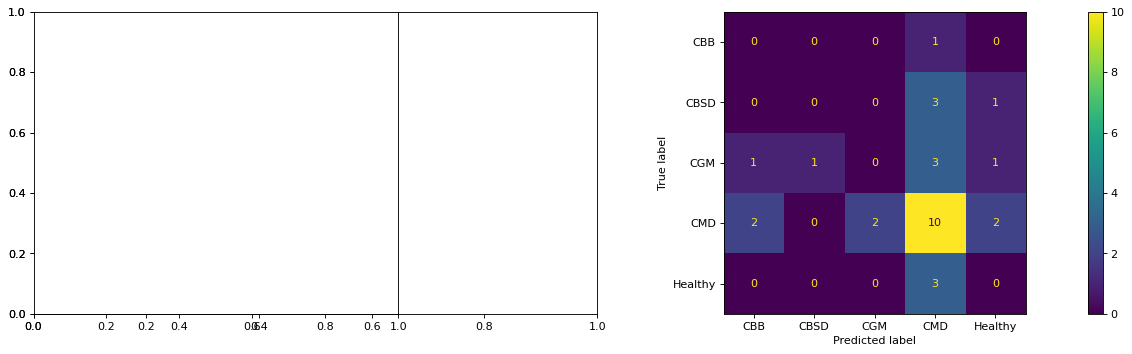

In [ ]:
fig = plt.figure(figsize=(20,5),dpi=80)
ax1 = fig.add_subplot(1,1,1)
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,3,1)

y_pred = pruned_10_model.predict(IG_test_subset,verbose=0)
y_pred = np.argmax(y_pred, axis=1)
labels = ['CBB','CBSD','CGM','CMD','Healthy']

cm1 = confusion_matrix(IG_test_subset.classes, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=labels)                                           
disp1.plot(ax=ax1)

In [ ]:
test = predict_model(interpreter_prune_80_16_bit,1)

[[2.8673423e-05 1.9549651e-04 3.7684609e-04 9.9892718e-01 4.7179405e-04]]
[2.8673423e-05 1.9549651e-04 3.7684609e-04 9.9892718e-01 4.7179405e-04]


In [ ]:
y_pred[0]
label_map

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [ ]:
# Load evaluation results from text files

accuracy_no_quant = []
accuracy_8_bit = []
accuracy_16_bit = []

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_no_quant'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_no_quant.append(float(l.replace('\n','').strip()))
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_8_bit'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_8_bit.append(float(l.replace('\n','').strip()))
file.close()

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'accuracy_16_bit'+'.txt','r')
lines = file.readlines()
for l in lines:
  accuracy_16_bit.append(float(l.replace('\n','').strip()))
file.close()

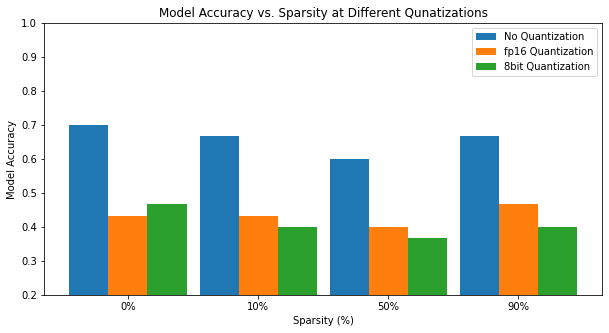

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
w = 0.3
ticks = [0,1,2,3]
ax = plt.subplot(111)
ax.bar([tick-w for tick in ticks],accuracy_no_quant,width=w,label='No Quantization')
ax.bar(ticks,accuracy_8_bit,width=w,label='fp16 Quantization')
ax.bar([tick+w for tick in ticks],accuracy_16_bit,width=w,label='8bit Quantization')
plt.xticks(ticks, ['0%', '10%', '50%', '90%'])
plt.xlabel('Sparsity (%)')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy vs. Sparsity at Different Qunatizations')
plt.legend()
plt.ylim(0.2,1)
plt.show()
     

In [ ]:
accuracy_no_quant

[0.7397196292877197,
 0.7191588878631592,
 0.6602803468704224,
 0.5514018535614014,
 0.7397196292877197,
 0.7191588878631592,
 0.6602803468704224,
 0.5514018535614014]

## Grad-CAM 

In [ ]:
# function to implement the grad-CAM algorithm

def gradCAM(model, image):
  """Implements Grad-CAM algorithm

  Args:
    model: an instantiated model
    image: 2D image under analysis
  Returns:
    Heatmap generated for input image to class.
  """
  # finds last convolutional layer in model
  for layer in reversed(model.layers):
    if len(layer.output_shape) == 4:
      if 'conv' in layer.name:
        layerName = layer.name
        break
  
  # instantiate newly defined model
  GC_Model = Model(inputs=[model.input], outputs=[model.get_layer(layerName).output, model.output])

  # automatic differentiation (comput a value and compute the derivatives of that value)
  with tf.GradientTape() as tape:
    (convOutputs, predictions) = GC_Model(np.expand_dims(image, axis=0))
    class_ind = np.argmax(predictions)
    loss = predictions[:, class_ind]
  grads = tape.gradient(loss, convOutputs)

  # compute alpha (average of gradient values)
  weights = tf.reduce_mean(grads[0], axis=(0,1))
  
  #perform weighted combination of feature map activations and alpha weights
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs[0]), axis=-1)

  # resize heatmap
  heatmap = cv2.resize(cam.numpy(), (image.shape[0], image.shape[1]))

  # apply ReLu to class discriminative map and normalize values
  # (only interested in features that have a positive effect on the class of interest)
  heatmap = np.maximum (heatmap, 0) / np.max(heatmap)

  # return resulting heatmap
  return heatmap
